<a href="https://colab.research.google.com/github/atran13/MSc-Thesis-Signs-of-Gentrification/blob/main/Code/model_iter2_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics

from __future__ import print_function, division

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchmetrics import ClasswiseWrapper, MetricCollection
# from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import time
import os, glob, copy, random
from PIL import Image
from pandas.core.common import flatten

cudnn.benchmark = True
# plt.ion()   # interactive mode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 11.6 MB/s eta 0:00:00


## Load Data

### Create train-val-test split in data paths

In [ ]:
root_dir = '/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/resnet/SS'

In [ ]:
all_image_paths = []
classes = []

for data_path in glob.glob(root_dir + '/*'):
    classes.append(data_path.split('/')[-1])
    all_image_paths.append(glob.glob(data_path + '/*'))

all_image_paths = list(flatten(all_image_paths))
data_size = len(all_image_paths)
random.seed(25)
random.shuffle(all_image_paths)

gen_count = 0
non_count = 0
for path in all_image_paths:
  label = path.split('/')[-2]
  if label == 'gentrified':
    gen_count +=1
  else:
    non_count +=1

print('Image path example: ', all_image_paths[0:3])
print('Classes: ', classes)
print('Dataset size (all):', data_size)
print(f'Class ratio: gentrified - {gen_count} ({(100 * gen_count/data_size):.2f}%) | non-gentrified - {non_count} ({(100 * non_count/data_size):.2f}%)')
print('------')

# split train val test from all paths (80,10,10)
train_image_paths, test_image_paths = all_image_paths[:int(0.8*len(all_image_paths))], all_image_paths[int(0.8*len(all_image_paths)):]
val_image_paths, test_image_paths = test_image_paths[:int(0.5*len(test_image_paths))], test_image_paths[int(0.5*len(test_image_paths)):]

for subset in (train_image_paths, val_image_paths, test_image_paths):
  subset_size = len(subset)
  gen_count = 0
  non_count = 0
  for path in subset:
    label = path.split('/')[-2]
    if label == 'gentrified':
      gen_count +=1
    else:
      non_count +=1
  print(f"Subset size: {subset_size}")
  print(f'Class ratio: gentrified - {gen_count} ({(100 * gen_count/subset_size):.2f}%) | non-gentrified - {non_count} ({(100 * non_count/subset_size):.2f}%)')
  print('---')

Image path example:  ['/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/resnet/SS/non-gentrified/osm-node-2721945914_poly-4.jpg', '/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/resnet/SS/non-gentrified/733_rec-8.jpg', '/content/drive/MyDrive/MASTERS/Thesis/Data/in_use/resnet/SS/non-gentrified/243_rec-1.jpg']
Classes:  ['gentrified', 'non-gentrified']
Dataset size (all): 10079
Class ratio: gentrified - 2610 (25.90%) | non-gentrified - 7469 (74.10%)
------
Subset size: 8063
Class ratio: gentrified - 2092 (25.95%) | non-gentrified - 5971 (74.05%)
---
Subset size: 1008
Class ratio: gentrified - 238 (23.61%) | non-gentrified - 770 (76.39%)
---
Subset size: 1008
Class ratio: gentrified - 280 (27.78%) | non-gentrified - 728 (72.22%)
---


In [ ]:
# num_all = len(data_train)
# indices = list(range(num_all))

# train_indices, test_indices = train_test_split(indices, test_size=.09, random_state=25,
#                                                stratify=data_train.targets)
# data_train = torch.utils.data.Subset(data_train, train_indices)
# data_test = torch.utils.data.Subset(data_test, test_indices)

# train_indices1, val_indices = train_test_split(train_indices, test_size=.1, random_state=25,
#                                               stratify=[data_train.dataset.targets[i] for i in train_indices])
# data_train = torch.utils.data.Subset(data_train, train_indices1)
# data_val = torch.utils.data.Subset(data_val, val_indices)

### Define custom dataset and transformations

In [ ]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
print(idx_to_class)
print(class_to_idx)

{0: 'gentrified', 1: 'non-gentrified'}
{'gentrified': 0, 'non-gentrified': 1}


In [ ]:
class Gentrification(ImageFolder):
  def __init__(self, paths, train=False):
    self.paths = paths
    self.transform = train
    self.data =[]
    for path in paths:
      class_name = path.split('/')[-2]
      self.data.append([path, class_name])
    # self.class_map = {"non-gentrified" : 0, "gentrified": 1}
    # self.rev_class_map = {0 : "non-gentrified", 1 : "gentrified"}

  def __len__(self) :
    return len(self.data)

  def __getitem__(self, idx):
    img_path, label = self.data[idx]
    img = Image.open(img_path)
    label = class_to_idx[label]

    if self.transform:
      return transform_train(img), label
    else:
      return transform_val_test(img), label

In [ ]:
def transform_train(i):
  transform = transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
  t = transform(i)
  return t

def transform_val_test(i):
  transform = transforms.Compose([
      transforms.Resize(224),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])
  t = transform(i)
  return t

### Load data

In [ ]:
# data_train = Gentrification(train_image_paths, train=True)
# data_val = Gentrification(val_image_paths, train=False)
data_test = Gentrification(test_image_paths, train=False)

In [ ]:
dataloaders = {
    # 'train': torch.utils.data.DataLoader(data_train, batch_size=32, shuffle=True, num_workers=2),
    # 'val': torch.utils.data.DataLoader(data_val, batch_size=32, num_workers=2),
    'test': torch.utils.data.DataLoader(data_test, batch_size=32, num_workers=2)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
# print(next(iter(dataloaders['train'])))

In [ ]:
dataset_sizes = {
    # 'train' : len(data_train),
    # 'val' : len(data_val),
    'test' : len(data_test)
}
print(dataset_sizes)

{'test': 1008}


In [ ]:
inputs, labels = next(iter(dataloaders['val']))
# labels.view(len(labels)).size()
print(labels.type())
print(labels.shape)
print(labels.dim())
# labels.squeeze().shape

torch.LongTensor
torch.Size([32])
1


### Visualize images



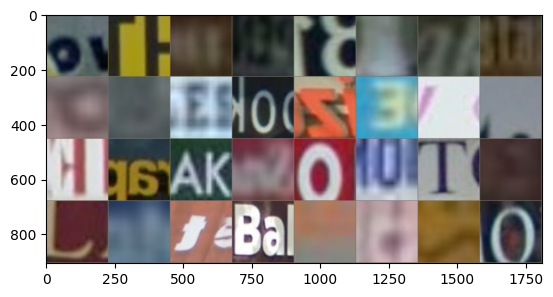

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

## Train & test functions



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_F1 = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # Metrics
            running_loss = 0.0
            # metrics = MetricCollection({
            #     'Acc' : BinaryAccuracy(),
            #     'P' : BinaryPrecision(),
            #     'R' : BinaryRecall(),
            #     'F1' : BinaryF1Score(),
            #     })
            metrics = MetricCollection({
                'Acc' : MulticlassAccuracy(num_classes=2, average='macro'),
                'P' : MulticlassPrecision(num_classes=2, average='macro'),
                'R' : MulticlassRecall(num_classes=2, average='macro'),
                'F1' : MulticlassF1Score(num_classes=2, average='macro'),
                })
            metrics = metrics.to(device)
            cls_metrics = MetricCollection({
                'cls_Acc' : ClasswiseWrapper(MulticlassAccuracy(num_classes=2, average=None)),
                'cls_P' : ClasswiseWrapper(MulticlassPrecision(num_classes=2, average=None)),
                'cls_R' : ClasswiseWrapper(MulticlassRecall(num_classes=2, average=None)),
                'cls_F1' : ClasswiseWrapper(MulticlassF1Score(num_classes=2, average=None))
                })
            cls_metrics = cls_metrics.to(device)

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                metrics.update(preds, labels.data)
                cls_metrics.update(preds, labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_metrics = metrics.compute()
            epoch_cls_metrics = cls_metrics.compute()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_metrics["Acc"].item():.4f} P: {epoch_metrics["P"].item():.4f} R: {epoch_metrics["R"].item():.4f} F1: {epoch_metrics["F1"].item():.4f}')

            # deep copy the model
            if phase == 'val' and epoch_metrics['F1'] > best_F1:
                best_metrics = epoch_metrics
                best_cls_metrics = epoch_cls_metrics
                best_model_wts = copy.deepcopy(model.state_dict())

            metrics.reset()
            cls_metrics.reset()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Metrics of best model: Acc: {best_metrics["Acc"].item():.4f} P: {best_metrics["P"].item():.4f} R: {best_metrics["R"].item():.4f} F1: {best_metrics["F1"].item():.4f}')
    print('Classwise metrics of best model:')
    for k,v in best_cls_metrics.items():
        print(f'{k}: {v.item():.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def test_model(model):
    running_loss = 0.0
    # metrics = MetricCollection({
    #     'Acc' : BinaryAccuracy(),
    #     'P' : BinaryPrecision(),
    #     'R' : BinaryRecall(),
    #     'F1' : BinaryF1Score()
    #     })
    metrics = MetricCollection({
        'Acc' : MulticlassAccuracy(num_classes=2, average='macro'),
        'P' : MulticlassPrecision(num_classes=2, average='macro'),
        'R' : MulticlassRecall(num_classes=2, average='macro'),
        'F1' : MulticlassF1Score(num_classes=2, average='macro'),
        })
    metrics = metrics.to(device)
    cls_metrics = MetricCollection({
        'cls_Acc' : ClasswiseWrapper(MulticlassAccuracy(num_classes=2, average=None)),
        'cls_P' : ClasswiseWrapper(MulticlassPrecision(num_classes=2, average=None)),
        'cls_R' : ClasswiseWrapper(MulticlassRecall(num_classes=2, average=None)),
        'cls_F1' : ClasswiseWrapper(MulticlassF1Score(num_classes=2, average=None))
        })
    cls_metrics = cls_metrics.to(device)

    with torch.no_grad():
        model.eval()
        for inputs,labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            metrics.update(preds, labels.data)
            cls_metrics.update(preds, labels.data)

        test_loss = running_loss / dataset_sizes['test']
        test_metrics = metrics.compute()
        test_cls_metrics = cls_metrics.compute()

        print(f'Test Loss: {test_loss:.4f} Acc: {test_metrics["Acc"].item():.4f} P: {test_metrics["P"].item():.4f} R: {test_metrics["R"].item():.4f} F1: {test_metrics["F1"].item():.4f}')
        print('Test classwise metrics:')
        for k,v in test_cls_metrics.items():
            print(f'{k}: {v.item():.4f}')

### Visualizing the model predictions

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Fixed feature extractor




In [ ]:
model_SS = torchvision.models.resnet50(weights='IMAGENET1K_V1')
for param in model_SS.parameters():
    param.requires_grad = False

num_ftrs = model_SS.fc.in_features
model_SS.fc = nn.Linear(num_ftrs, 2)

model_SS = model_SS.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(model_SS.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 105MB/s]


### Train and evaluate

In [ ]:
model_SS = train_model(model_SS, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.5068 {'F1': tensor(0.8529, device='cuda:0'), 'P': tensor(0.7723, device='cuda:0'), 'R': tensor(0.9523, device='cuda:0'), 'acc': tensor(0.7568, device='cuda:0')}
val Loss: 0.5280 {'F1': tensor(0.8495, device='cuda:0'), 'P': tensor(0.7865, device='cuda:0'), 'R': tensor(0.9234, device='cuda:0'), 'acc': tensor(0.7500, device='cuda:0')}

Epoch 1/49
----------
train Loss: 0.5055 {'F1': tensor(0.8514, device='cuda:0'), 'P': tensor(0.7701, device='cuda:0'), 'R': tensor(0.9519, device='cuda:0'), 'acc': tensor(0.7539, device='cuda:0')}
val Loss: 0.5304 {'F1': tensor(0.8553, device='cuda:0'), 'P': tensor(0.7817, device='cuda:0'), 'R': tensor(0.9442, device='cuda:0'), 'acc': tensor(0.7560, device='cuda:0')}

Epoch 2/49
----------
train Loss: 0.5084 {'F1': tensor(0.8526, device='cuda:0'), 'P': tensor(0.7715, device='cuda:0'), 'R': tensor(0.9528, device='cuda:0'), 'acc': tensor(0.7560, device='cuda:0')}
val Loss: 0.5278 {'F1': tensor(0.8546, device='cuda:0'), 'P':

In [ ]:
torch.save(model_SS.state_dict(), "/content/drive/MyDrive/MASTERS/Thesis/Code/models/Train&Val&Test=SS/model_SS_iter2_rev-map.pth")

### Test

In [ ]:
model_SS_test = torchvision.models.resnet50()
num_ftrs = model_SS_test.fc.in_features
model_SS_test.fc = nn.Linear(num_ftrs, 2)

model_pth = '/content/drive/MyDrive/MASTERS/Thesis/Code/models/Train&Val&Test=SS/model_SS_iter2_rev-map.pth'
model_SS_test.load_state_dict(torch.load(model_pth))
model_SS_test.to(device)

criterion = nn.CrossEntropyLoss()

In [ ]:
test_model(model_SS_test)
# {'gentrified': 0, 'non-gentrified': 1}

Test Loss: 0.5194 Acc: 0.5810 P: 0.6852 R: 0.5810 F1: 0.5800
Test classwise metrics:
multiclassaccuracy_0: 0.2143
multiclassaccuracy_1: 0.9478
multiclassf1score_0: 0.3175
multiclassf1score_1: 0.8425
multiclassprecision_0: 0.6122
multiclassprecision_1: 0.7582
multiclassrecall_0: 0.2143
multiclassrecall_1: 0.9478
